In [1]:
# CONECTAR CON DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
path ='/content/drive/MyDrive/cod/LEA3_Marketing'
os.chdir(path) ## volver la carpeta de repositorio directorio de trabajo
sys.path.append(path) ## agregarla al path, para leer archivos propios como paquetes

In [14]:
# LIBRERIAS
import numpy as np
import pandas as pd
import sqlite3 as sql
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
import a_funciones as fn
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql ### paquete para crear y trabajar bases de datos ligeras

In [4]:
# CREAR CONEXIÓN CON LA BASE DE DATOS db_movies
con = sql.connect('data/db_movies')

# CREAR EL CURSOR
cur = con.cursor() ## se crea el cursor, que es el otro tipo de conexión para ejecutar las consultas

In [5]:
# VERIFICAR LOS NOMBRES DE TODAS LAS TABLAS QUE HAY EN LA BASE DE DATOS
cur.execute(""" select name from sqlite_master where type= 'table'  """)
cur.fetchall()

[('ratings',), ('movies',)]

Se confirma la información del trabajo, y es que la empresa cuenta con una base de datos sql “bd_movies” en la cuál se encuentran **dos tablas**. Una tabla tiene la información del catálogo de películas disponibles en la plataforma llamada ‘movies’. Los campos que tiene esta tabla son:

*  **movieId**: código que identifica la película
*  **title**: Nombre y año de la película
*  **genres**: Lista de géneros a los que pertenece la película.  

La segunda tabla es una lista de los usuarios y las películas que vieron, las fechas en las que las vieron y la calificación que le dieron a la película. Los campos son:

* **userId**: Código que identifica al usuario.
* **movieId**: Código que identifica la película.
* **Rating**: Calificación de la película vista de 1 a 5.
* **Timestamp**: Timestamp de la fecha en la que fue vista la película.


# **TABLAS QUE CONTIENE LA BASE DE DATOS**

In [6]:
# VERIFICAMOS LA PRIMERA TABLA "raitings"
db_ratings = pd.read_sql('SELECT * FROM ratings', con)
db_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# VERIFICAMOS LA SEGUNDA TABLA "movies"
db_movies = pd.read_sql('SELECT * FROM movies', con)
db_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## **Exploración inicial**

In [ ]:
# Número de usuarios en la tabla ratings que han calificado peliculas
pd.read_sql("""SELECT COUNT(DISTINCT userId) AS total_usuarios FROM ratings""", con)

,total_usuarios
0,610


In [ ]:
## promedio de calificación de la pelicula con id 1
pd.read_sql("""SELECT AVG(rating) as promedio_rating FROM ratings where MovieId=1""",con)

,promedio_rating
0,3.92093


In [ ]:
db_ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [8]:
# Conteo de calificaciones
cr = pd.read_sql("""
    SELECT
        rating,
        COUNT(*) AS conteo
    FROM ratings
    GROUP BY rating
    ORDER BY conteo DESC
""", con)

# Gráfico de barras
data = go.Bar(
    x=cr.rating,
    y=cr.conteo,
    text=cr.conteo,
    textposition="outside"
)

layout = go.Layout(
    title="Distribución de calificaciones de películas",
    xaxis={'title': 'Calificación'},
    yaxis={'title': 'Cantidad'}
)

go.Figure(data=[data], layout=layout).show()

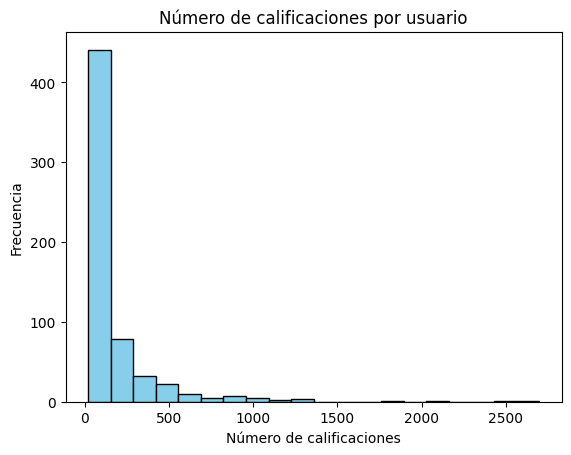

In [42]:
# Obtener número de calificaciones por usuario
rating_users = pd.read_sql('''
    SELECT userId AS user_id,
           COUNT(*) AS cnt_rat
    FROM ratings
    GROUP BY userId
    ORDER BY cnt_rat ASC
''', con)

# Histograma del número de calificaciones por usuario
plt.hist(rating_users['cnt_rat'], bins=20, color='skyblue', edgecolor='black')
plt.title('Número de calificaciones por usuario')
plt.xlabel('Número de calificaciones')
plt.ylabel('Frecuencia')
plt.show()


In [44]:
rating_users

,user_id,cnt_rat
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
605,274,1346
606,448,1864
607,474,2108
608,599,2478


In [11]:

rating_users.describe()

,user_id,cnt_rat
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


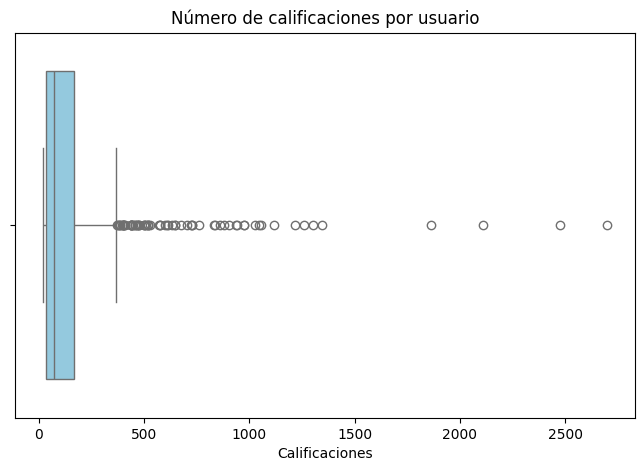

In [19]:
# Boxplot número de peliculas calificadas por usuario
plt.figure(figsize=(8, 5))
sns.boxplot(x=rating_users['cnt_rat'], color='skyblue')
plt.title('Número de calificaciones por usuario')
plt.xlabel('Calificaciones')
plt.show()

>La mayoria de usarios tiene pocas películas calificadas, pero los que mas tienen, son demasiadas, siendo un número improbable

>Excluir usuarios con menos de 20 películas calificadas (para tener calificación confiable) y los que tienen más de 300 porque ya no sería un valor razonable

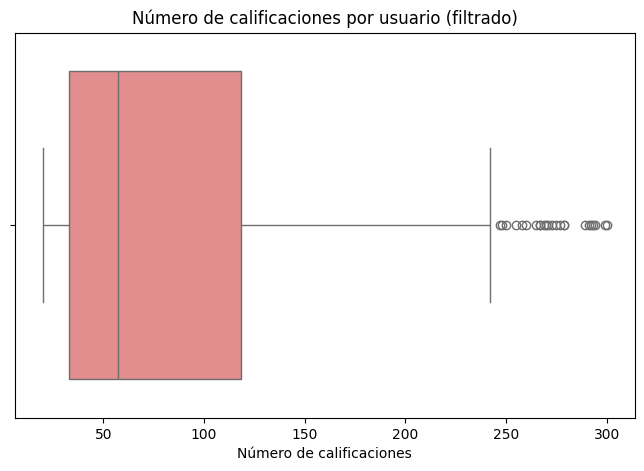

In [45]:
# Filtrar usuarios con entre 5 y 500 calificaciones
rating_users2 = pd.read_sql('''
    SELECT userId AS user_id,
           COUNT(*) AS cnt_rat
    FROM ratings
    GROUP BY userId
    HAVING cnt_rat >= 20 AND cnt_rat <= 300
    ORDER BY cnt_rat ASC
''', con)

plt.figure(figsize=(8, 5))
sns.boxplot(x=rating_users2['cnt_rat'], color='lightcoral')
plt.title('Número de calificaciones por usuario (filtrado)')
plt.xlabel('Número de calificaciones')
plt.show()

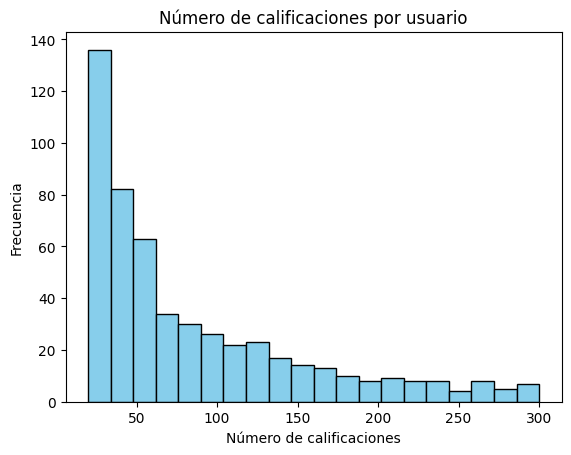

In [46]:
# Histograma del número de calificaciones por usuario
plt.hist(rating_users2['cnt_rat'], bins=20, color='skyblue', edgecolor='black')
plt.title('Número de calificaciones por usuario')
plt.xlabel('Número de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [47]:
# Descripción después de los filtros
rating_users2.describe()

,user_id,cnt_rat
count,527.000000,527.000000
mean,304.197343,85.079696
std,173.397977,68.833582
min,1.000000,20.000000
25%,154.500000,33.000000
50%,306.000000,57.000000
75%,451.500000,118.500000
max,609.000000,300.000000


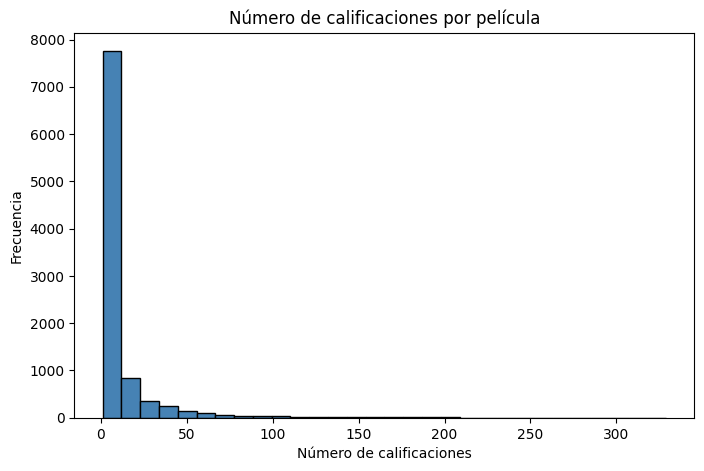

In [50]:
# Verificar cuántas calificaciones tiene cada película
rating_movies = pd.read_sql('''
    SELECT movieId,
           COUNT(*) AS cnt_rat
    FROM ratings
    GROUP BY movieId
    ORDER BY cnt_rat DESC
''', con)


# Graficar distribución
plt.figure(figsize=(8, 5))
plt.hist(rating_movies['cnt_rat'], bins=30, color='steelblue', edgecolor='black')
plt.title('Número de calificaciones por película')
plt.xlabel('Número de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [49]:
# Distribución de calificaciones por película
rating_movies.describe()

,movieId,cnt_rat
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


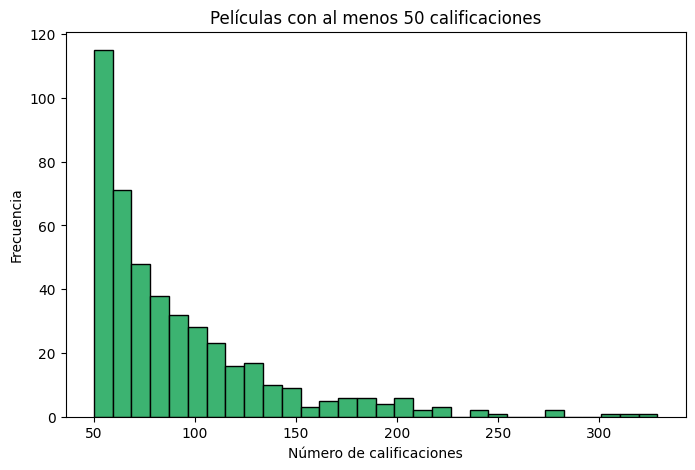

In [57]:
####Excluir películas que no tengan más de 50 calificaciones
rating_movies2=pd.read_sql('''
SELECT movieId ,
        COUNT(*) as cnt_rat
FROM ratings
GROUP BY "movieId"
HAVING cnt_rat>=50
ORDER BY cnt_rat DESC
''',con )

plt.figure(figsize=(8, 5))
plt.hist(rating_movies2['cnt_rat'], bins=30, color='mediumseagreen', edgecolor='black')
plt.title('Películas con al menos 50 calificaciones')
plt.xlabel('Número de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [60]:
rating_movies2.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,450.0,11245.017778,23457.084170,1.0,757.0,2020.0,4994.50,122904.0
cnt_rat,450.0,91.911111,46.098385,50.0,59.0,76.0,107.75,329.0


In [ ]:
## consulta de peliculas que estan en la tabla movies, que no tienen calificacion alguna en la tabla ratings
pd.read_sql(
    """SELECT movies.title
    FROM movies
    LEFT JOIN ratings ON movies.movieId = ratings.movieId
    WHERE ratings.rating IS NULL""", con)

,title
0,"Innocents, The (1961)"
1,Niagara (1953)
2,For All Mankind (1989)
3,"Color of Paradise, The (Rang-e khoda) (1999)"
4,I Know Where I'm Going! (1945)
5,"Chosen, The (1981)"
6,"Road Home, The (Wo de fu qin mu qin) (1999)"
7,Scrooge (1970)
8,Proof (1991)
9,"Parallax View, The (1974)"


In [ ]:
###  Películas que tienen solo 1 evaluación
pd.read_sql("""
    SELECT movies.title
    FROM movies
    LEFT JOIN ratings ON movies.movieId = ratings.movieId
    GROUP BY movies.movieId
    HAVING COUNT(ratings.rating) = 1""", con)

,title
0,When Night Is Falling (1995)
1,Georgia (1995)
2,Nico Icon (1995)
3,Once Upon a Time... When We Were Colored (1995)
4,In the Bleak Midwinter (1995)
...,...
3441,Black Butler: Book of the Atlantic (2017)
3442,No Game No Life: Zero (2017)
3443,Flint (2017)
3444,Bungo Stray Dogs: Dead Apple (2018)


In [ ]:
from mlxtend.preprocessing import TransactionEncoder # Procesar datos en estructrura transaccional

genres=db_movies['genres'].str.split('|')
te = TransactionEncoder()
genres = te.fit_transform(genres)
genres = pd.DataFrame(genres, columns = te.columns_)
len(db_movies['genres'].unique())

In [ ]:
### genero de pelicula que ocupa la posicion 9 de los que tienen mas peliculas
df = pd.read_sql("SELECT genres FROM movies", con) ## seleccionamos de la tabla peliculas la columna de genres

df_nuevo = df.assign(genres=df["genres"].str.split("|")).explode("genres") ## estos al estar separados por | se generan listas para luego separarlos en la misma columna
df_nuevo["genres"].value_counts().reset_index().iloc[8] ## se cuentan cuantas veces aparecen los generos y usando la posicion 8 se ubica el genero que ocupa la novena posicion

,8
genres,Horror
count,978


In [ ]:
db_movies["año"] = db_movies["title"].str.extract('(\(\d{4}\))', expand=False).str.strip('()').astype(float)
db_movies["año"] = pd.to_numeric(db_movies["año"], errors='coerce').astype('Int64')

In [ ]:
sep=movies['title'].str.split('(')

year=sep.str[1].str.replace(')','')
title=sep.str[0]

In [ ]:
db_movies = db_movies.join(db_movies["genres"].str.get_dummies(sep="|"))
db_movies

,movieId,title,genres,año,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,2017,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
db_movies.head(5)

,movieId,title,genres,año,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings=pd.read_sql('select * from ratings', con)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings['fecha'] = pd.to_datetime(ratings['timestamp'], unit='s')  ## para cambiar el timestamp

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp,fecha
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51


In [ ]:
#Contando cuántas veces un usuario dio una calificación de 5 y el promedio de calificación por usuario

pd.read_sql("""
    SELECT "userId",
        COUNT(CASE WHEN "rating" = 5 THEN 1 END) AS total_5_por_usuario,
        AVG("rating") AS promedio_user
    FROM ratings
    GROUP BY "userId"
    order by promedio_user desc
""", con)

,userId,total_5_por_usuario,promedio_user
0,53,20,5.000000
1,251,21,4.869565
2,515,21,4.846154
3,25,20,4.807692
4,30,27,4.735294
...,...,...,...
605,567,14,2.245455
606,153,5,2.217877
607,508,0,2.145833
608,139,0,2.144330


In [ ]:
# Promedio de calificaciones para cada película.

pd.read_sql("""
    SELECT "movieId", AVG("rating") AS promedio_pelicula
    FROM ratings
    GROUP BY "movieId"
    ORDER BY promedio_pelicula DESC
""", con)

,movieId,promedio_pelicula
0,187717,5.0
1,184245,5.0
2,179135,5.0
3,179133,5.0
4,176601,5.0
...,...,...
9719,4580,0.5
9720,4371,0.5
9721,4051,0.5
9722,3933,0.5


In [ ]:
con.close() ## Cerrar conexion